<a href="https://colab.research.google.com/github/jnsbrdbr/machine_learning_pojects/blob/master/Emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout,Activation,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from keras.models import Sequential
from keras.optimizers import rmsprop_v2
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras.models import load_model
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os
from keras.utils.np_utils import to_categorical
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read images and store them in a dataframe.

In [ ]:
int2emotions = {0:'angry',1:'fear',2:'happy',3:'neutral',4:'sad',5:'surprise'}
emotions2int = {'angry':0,'fear':1,'happy':2,'neutral':3,'sad':4,'surprise':5}
dic = {'images':[], 'labels':[], 'purpose':[]}
    
for d in os.listdir('/content/drive/MyDrive/emotion'):
    #print(d)
    for emotion in os.listdir(f'/content/drive/MyDrive/emotion/{d}'):
        #print(emotion)
        for i in os.listdir(f'/content/drive/MyDrive/emotion/{d}/{emotion}'):
            img = cv2.imread(f'/content/drive/MyDrive/emotion/{d}/{emotion}/{i}',0)#load and read imags in img and 0 is flag for gray scale
            img = img.reshape(48,48,1)
            
            dic['images'].append(img)
            dic['labels'].append(emotion)
            
            if d=='train':
                dic['purpose'].append('T')
            else:
                dic['purpose'].append('V')
df = pd.DataFrame(dic)
df.head()

In [ ]:
train_data = df[df['purpose']=='T']
val_data = df[df['purpose']=='V']

In [ ]:
train_data.head()

In [ ]:
val_data.head() #get rows

In [ ]:
train_data['labels'].value_counts()

In [ ]:
#should become balance
happy_df = train_data[train_data['labels']=='happy'].sample(n=3171)
neutral_df = train_data[train_data['labels']=='neutral'].sample(n=3171)
sad_df = train_data[train_data['labels']=='sad'].sample(n=3171)
fear_df = train_data[train_data['labels']=='fear'].sample(n=3171)
angry_df = train_data[train_data['labels']=='angry'].sample(n=3171)
surprise_df = train_data[train_data['labels']=='surprise'].sample(n=3171)

train_data = pd.concat([happy_df,neutral_df,sad_df,fear_df,angry_df,surprise_df])

train_data = train_data.sample(frac=1)
train_data.reset_index(inplace=True)
train_data.drop('index',inplace=True,axis=1)

train_data.head()

In [ ]:
train_data['labels'].value_counts()

In [ ]:
batch_size= 32
classes = 6
rows,columns=48,48

In [ ]:
emotions2int = {'angry':0,'fear':1,'happy':2,'neutral':3,'sad':4,'surprise':5}

In [ ]:
train_labels1 =train_data.replace({'labels':emotions2int})
train_labels = to_categorical(train_labels1.labels)
print(train_labels)


In [ ]:
val_labels1 = val_data.replace({'labels':emotions2int})
val_labels = to_categorical(val_labels1.labels)
print(val_labels)

In [ ]:
train_data = list(train_data['images'])
train_data = np.array(train_data)
val_data = list(val_data['images'])
val_data = np.array(val_data)

In [ ]:
train_data.shape

In [ ]:
model = Sequential()

# First Block
model.add(Conv2D(64,(3,3),activation='elu',input_shape=(rows,columns,1),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='elu',input_shape=(rows,columns,1),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Second Block
model.add(Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Third Block
model.add(Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fourth Block
model.add(Conv2D(512,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fifth Block
model.add(Flatten())
model.add(Dense(256,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Sixth Block
model.add(Dense(128,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Seventh Block
model.add(Dense(64,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Eighth Block
model.add(Dense(classes,activation='softmax',kernel_initializer='he_normal'))

print(model.summary())

In [ ]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/emotion/class_emotion_detector_V2.h5',
                             save_best_only=True,
                             mode='min',
                             monitor='val_loss',
                             verbose=1)

earlystopping = EarlyStopping(patience=10,
                             verbose=1,
                             min_delta=0,
                             monitor='val_loss',
                             restore_best_weights=True)


callbacks = [checkpoint, earlystopping]

model.compile(metrics=['accuracy'],
             optimizer='rmsprop',
             loss='categorical_crossentropy')

In [ ]:
train_samples = 28273
validation_samples = 3534
batch_size = 64
epochs=30

history = model.fit(train_data,
                    train_labels,
                    epochs=epochs,
                    steps_per_epoch=train_samples//batch_size,
                    validation_data=(val_data,val_labels),
                    validation_steps=validation_samples//batch_size,
                    callbacks=callbacks)

1/1 [==============================] - 0s 32ms/step


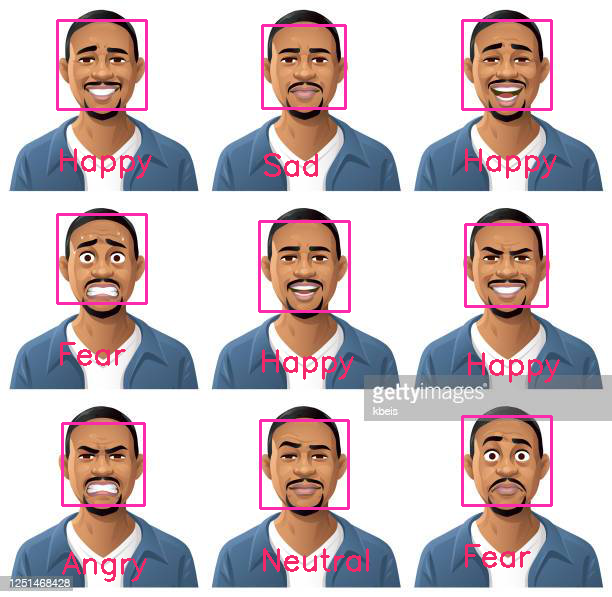

In [40]:
from keras.models import load_model
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt


int2emotions = {0:'Angry',1:'Fear',2:'Happy',3:'Neutral',4:'Sad',5:'Surprise'}
model = load_model('/content/drive/MyDrive/emotion/class_emotion_detector_V2.h5')
#cap = cv2.VideoCapture(0)

classifier = cv2.CascadeClassifier('/content/drive/MyDrive/emotion/haarcascade_frontalface_default.xml')

def detect_face(frame):
    faces=classifier.detectMultiScale(frame,1.3,4)
    if faces==():
        return frame
    for x,y,w,h in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(172,42,251),2)
        face = frame[y:y+h,x:x+w]
        face = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
        face = cv2.resize(face,(48,48))
        face = face.reshape(1,48,48,1)
        cv2.putText(frame,text=int2emotions[np.argmax(model.predict(face))],
                    org=(x,y+150),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(106,40,243),thickness=2)
    return frame
import warnings
warnings.filterwarnings('ignore')
img=io.imread('/content/drive/MyDrive/emotion/1.jpg')
image_2 = cv.cvtColor(img, cv.COLOR_BGR2RGB)
a=detect_face(image_2)
cv2_imshow(a)



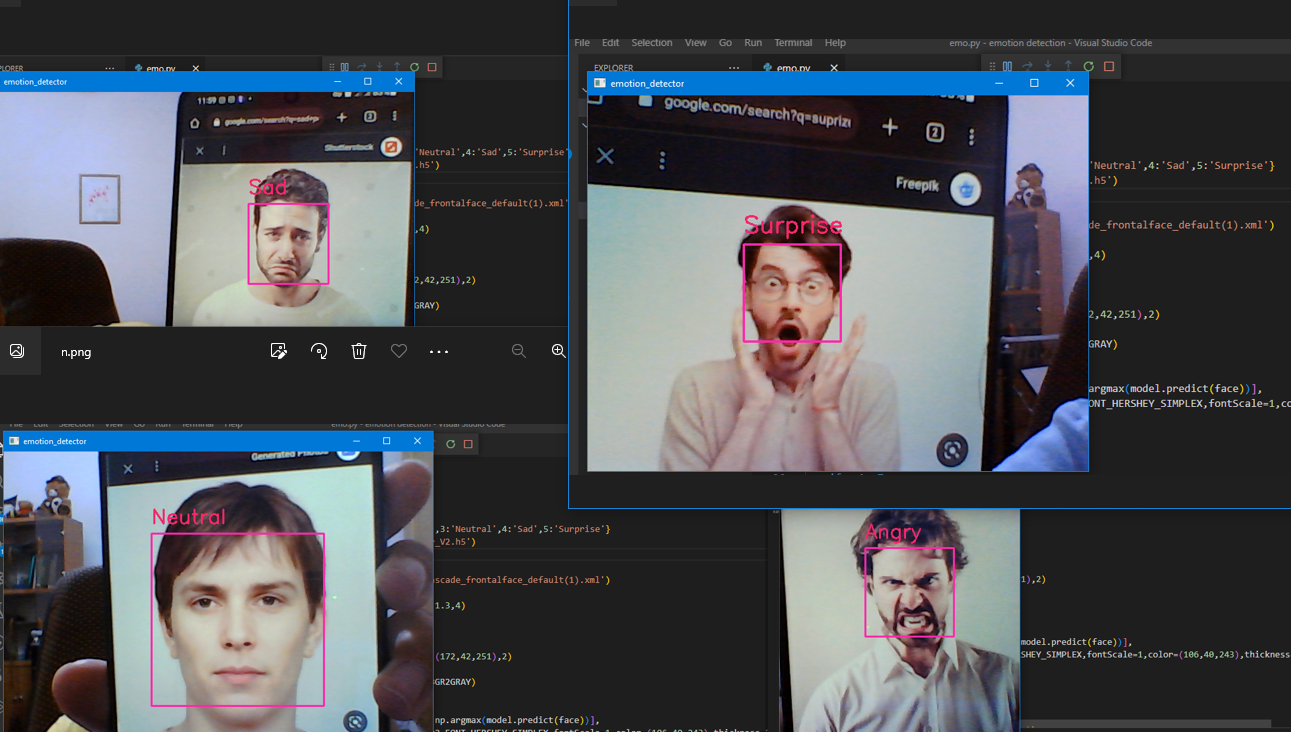

In [29]:
#also live emotion detection on my pc and its result
import numpy as np
import pandas as pd
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt

img=io.imread('/content/drive/MyDrive/emotion/yes.png')
image_2 = cv.cvtColor(img, cv.COLOR_BGR2RGB)
cv2_imshow(image_2)

